# 10 프로젝트 : 한국어 데이터 챗봇 생성
### 데이터 : [한국어 데이터](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)
### 모델 : transformer
## 0. 라이브러리

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import re
import time
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

c:\Users\lkg\Desktop\vscode\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 데이터 수집
- 한국어 데이터
- 변수 : Q, A, label

In [2]:
data = pd.read_csv("C:/Users/lkg/Desktop/vscode\AIFFEL QUEST\Exploration\Quest7/ChatbotData.csv")
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


### 1.1 데이터 기본 정보 확인
- 데이터 내 결측치
- 데이터 샘플 갯수

In [3]:
print(data.isnull().sum())
print(len(data))

Q        0
A        0
label    0
dtype: int64
11823


## 2. 데이터 전처리
### 2.1 샘플의 최대 갯수 설정
- 데이터가 많지 않으므로 모두 사용

In [4]:
MAX_SAMPLES = len(data)
print(MAX_SAMPLES)

11823


### 2.2 전처리 함수 정의
- 일부 영어 데이터의 소문자화
  - ex): SNS -> sns, SD -> sd
- 양쪽 공백 제거
  - 일관성 확보
- 구두점 사이 거리
  - 단어 구분, 토큰화 용이성
- 예외 문자 처리
  - 공백으로 대체 - [참고](https://signing.tistory.com/74)

In [5]:
# 전처리 함수 정의
def preprocess_sentence(sentence):
  # 소문자화, 양쪽 공백 제거
  sentence = sentence.lower().strip()

  # 단어와 구두점 사이의 거리
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # 예외 문자를 공백으로 대체
  sentence = re.sub(r"[^a-zA-Z0-9가-힣?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

### 2.3 데이터 전처리 함수 적용
- 질문,답변 데이터 전처리
  - `tpdm()` : 진행률 표시
  - 전처리 함수에 적용 후 각각 `questions`, `answers`에 append

In [6]:
# 질문 데이터 전처리
questions = []

for sentence in tqdm(data['Q'], desc="데이터셋의 Q 컬럼 전처리 중..."):
    questions.append(preprocess_sentence(sentence))

# 답변 데이터 전처리
answers = []

for sentence in tqdm(data['A'], desc="데이터셋의 A 컬럼 전처리 중..."):
    answers.append(preprocess_sentence(sentence))

# 전처리 확인
print("Q 데이터 5개: {0}".format(questions[:5]))
print("A 데이터 5개: {0}".format(answers[:5]))

데이터셋의 A 컬럼 전처리 중...: 100%|██████████| 11823/11823 [00:00<00:00, 124427.92it/s]

Q 데이터 5개: ['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'ppl 심하네']
A 데이터 5개: ['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


## 3. SubwordTextEncoder
- 내부 토크나이저

## 3.1 단어장 생성
- SubwordTextEncoder로 단어 집합 생성
- 질문+답변 데이터 사용

In [7]:
# SubwordTextEncoder 단어장
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

### 3.1.1 시작 토큰, 종료 토큰
- 모델에게 입력 시퀀스의 시작을 나타내는 시작 토큰과 
- 종료 시퀀스의 끝을 나타내는 종료 토큰 정수 할당
  - 인덱스가 겹치지 않도록 설정 [단어장 끝], [끝+1]
  - 단어장 크기 : tokenizer + 2(시작, 종료)

In [8]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 단어장의 크기 산정
VOCAB_SIZE = tokenizer.vocab_size + 2

# 토큰의 번호와 단어 집합의 크기 확인
print("시작 토큰 번호 : {0}".format(START_TOKEN))
print("종료 토큰 번호 : {0}".format(END_TOKEN))
print("단어 집합의 크기 : {0}".format(VOCAB_SIZE))

시작 토큰 번호 : [8162]
종료 토큰 번호 : [8163]
단어 집합의 크기 : 8164


### 3.1.2 샘플의 최대 허용 길이 설정
- 샘플의 최대 허용 길이를 설정 = 패딩 후의 최종 길이
  - 질문과 답변의 분포를 확인하여 적절한 값 설정
  - ex): (최소,  최대,  평균 길이)

In [9]:
# 질문, 답변의 분포
Q_len = [len(s.split()) for s in data['Q']]
A_len = [len(s.split()) for s in data['A']]

print('질문의 최소 길이 : {}'.format(np.min(Q_len)))
print('질문의 최대 길이 : {}'.format(np.max(Q_len)))
print('질문의 평균 길이 : {}'.format(np.mean(Q_len)))

print('\n답변의 최소 길이 : {}'.format(np.min(A_len)))
print('답변의 최대 길이 : {}'.format(np.max(A_len)))
print('답변의 평균 길이 : {}'.format(np.mean(A_len)))

질문의 최소 길이 : 1
질문의 최대 길이 : 15
질문의 평균 길이 : 3.587414361837097

답변의 최소 길이 : 1
답변의 최대 길이 : 21
답변의 평균 길이 : 3.6936479742874058


In [10]:
# 샘플의 최대 허용 길이 설정
MAX_LENGTH = 20
print('샘플의 최대 허용 길이 : {}'.format(MAX_LENGTH))

샘플의 최대 허용 길이 : 20


## 3.2 인코딩, 패딩
- 각 단어를 고유한 정수로 인코딩(Inter encoding), 패딩(Padding)
### 3.2.1 토큰화, 필터 함수 정의
- 각 입력 (sentence1,sentence2) 토큰화
  - 추가 : `START_TOKEN`, `END_TOKEN` 토큰
- 길이 필터링
  - MAX_LENGTH 보다 짧은 경우만 데이터 셋으로 허용
- 패딩
  - 문장의 앞쪽(`pre`)에 '0' 추가
  - 데이터가 동일한 차원을 가짐

In [11]:
# 훈련 데이터셋 (질문, 답변)을 입력 -> 토큰화, 필터 함수
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
  for (sentence1, sentence2) in zip(inputs, outputs):
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='pre')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='pre')
  
  return tokenized_inputs, tokenized_outputs

### 3.2.2 단어장 크기, 샘플 개수 확인

In [12]:
# 단어장 크기와 샘플의 개수 확인
questions, answers = tokenize_and_filter(questions, answers)

print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8164
필터링 후의 질문 샘플 개수: 11792
필터링 후의 답변 샘플 개수: 11792


## 3.3 교사 강요 사용
- Teacher Forcing
  - 디코더의 입력과 실제값(레이블)을 정의 - [위키독스: RNN 언어모델](https://wikidocs.net/46496)
  - 자기회귀 모델(auto-regressive model, AR) : 
    - 이전 자신의 출력이 현재 자신의 상태를 결정하는 모델
- `tf.data.Dataset` API :
  - 훈련 프로세스의 속도가 빨라지도록 입력 파이프 라인 구축

### 3.3.1 교사 강요
- tf.data.Dataset API의 입력 : 질문과 답변의 쌍
- 디코더는 이전의 target을 다음의 input으로 사용
  - 디코더의 입력값 : answers[:, :-1] : 마지막 토큰을 제외한 데이터를 사용
  - 디코더의 레이블 : answers[:, 1:] : 첫 번째 토큰을 제외한 나머지 부분을 사용

In [13]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000


dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 4. 모델 구성
- 인코더
  - 0 임베딩 레이어 + 포지셔널 인코딩 레이어
  - 1 멀티 헤드 어텐션 (셀프 어텐션)
    - 스케일드 닷 프로덕트 어텐션
    - 패딩 마스크
  - 2 피드포워드 신경망
    - 완전 연결 층
- 디코더
  - 0 임베딩 레이어 + 포지셔널 인코딩 레이어
  - 1 멀티 헤드 어텐션 (셀프 어텐션)
    - 스케일드 닷 프로덕트 어텐션
    - 룩 어헤드 마스크
  - 2 멀티 헤드 어텐션 (인코더-디코더 어텐션)
    - 패딩 마스크
  - 3 피드포워드 신경망
    - 완전 연결 층
- transformer
  - 인코더 + 디코더

### 4.1.1 포지셔널 인코딩 레이어
- 포지셔널 인코딩 레이어

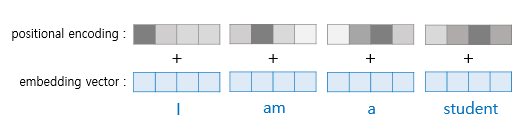
- 트랜스포머는 입력을 받을 때, 문장에 있는 모든 단어를 한꺼번에 입력으로 받음
  - 모델에게 어순 정보를 알려줌

In [14]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### 4.1.2 스케일드 닷 프로덕트 어텐션
- 스케일드 닷 프로덕트 어텐션

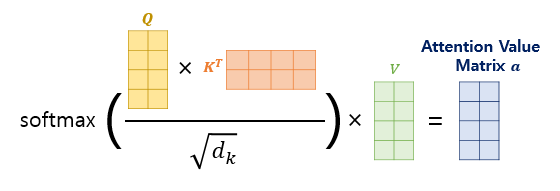
- 벡터의 유사도를 0과 1사이로 Normalize
  - 연산의 결과가 입력 벡터의 차원 수에 따라 크기가 매우 커짐 방지
  - softmax의 출력값이 작아지는 것을 방지
    - softmax의 출력값이 작아지면 역전파 과정에서 기울기 소실 문제가 발생

In [15]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

### 4.1.3 멀티-헤드 어텐션
- 멀티-헤드 어텐션

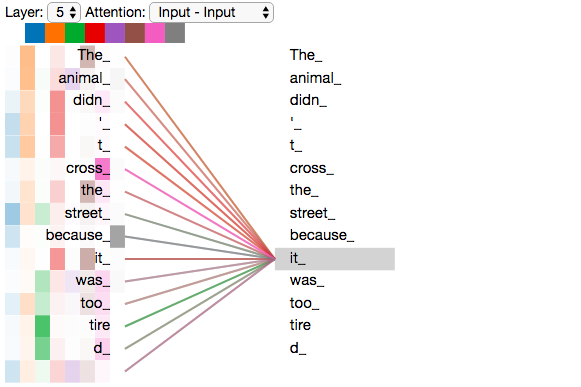
- 어텐션을 병렬로 수행
  - 각 어텐션이 서로 다른 셀프 어텐션 결과를 가져옴
  - 서로 다른 관점에서 정보를 놓침을 방지

In [16]:
# 멀티-헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  # 병렬 연산을 위한 입력 벡터의 헤드 수를 설정하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 생성
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결 (concatenate)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에 Dense를 한 번 더 적용
    outputs = self.dense(concat_attention)

    return outputs

## 4.2 마스킹
- 마스킹 :
  - 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법
- ex): 패딩 마스킹, 룩 어헤드 마스킹

### 4.2.1 패딩 마스킹

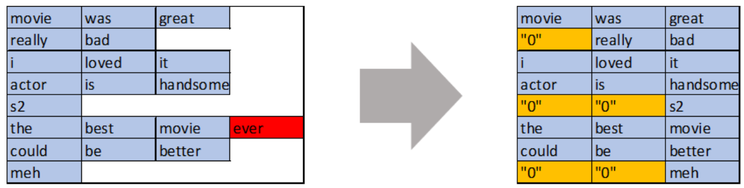
- 숫자 0은 실제 의미가 있는 단어가 아니므로, 실제 어텐션 등과 같은 연산에서는 제외 해야함
- => 숫자 0인 위치를 체크

In [17]:
# 패딩 마스킹 기능을 가지는 함수 선언
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

### 4.2.2 룩 어헤드 마스킹

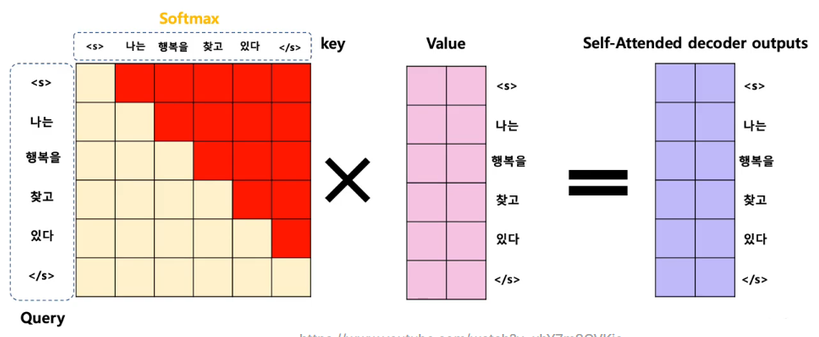
- 트랜스포머는 문장 행렬을 만들어 한 번에 행렬 형태로 입력으로 들어간다는 특징이 있음
  - 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있음
  - 목표 : 이전 단어들로부터 다음 단어를 예측하는 훈련
  - => Query 단어 뒤에 나오는 Key 단어들에 대해서는 마스킹

In [18]:
# 록어헤드 마스킹 기능을 가지는 함수 선언
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

## 4.3 트랜스포머 인코더 설계 (encoder layer part)
- 인코더 하나의 레이어를 함수로 구현
- 하나의 레이어 안에는 두 개의 서브 레이어가 존재
  - 셀프 어텐션, 피드 포워드 신경망
  
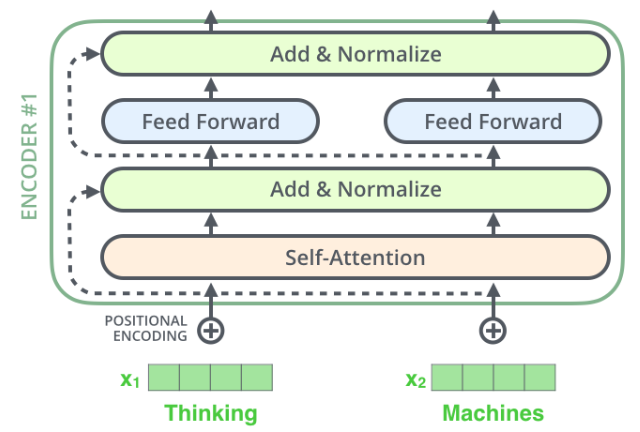
### 4.3.1 인코더 하나의 레이어 함수 정의

In [19]:
# 인코더 하나의 레이어 함수 정의
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  #################### 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션) ####################
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션 결과를 Dropout과 Layer Normalization
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  ##################### 두 번째 서브 레이어 : 2개의 완전연결층 (피드 포워드 신경망) ####################
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층 결과를 Dropout과 LayerNormalization
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 4.3.2 인코더 만들기
- 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결
- 인코더 층을 쌓아 원하는 만큼 반복
  - 파라미터 : num_layers

In [20]:
# 인코더 함수 선언; Transformer의 인코더
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

## 4.4 트랜스포머 디코더 설계 (decoder layer part)
- 디코더 하나의 레이어를 함수로 구현
- 하나의 레이어 안에는 세 개의 서브 레이어가 존재
  - 셀프 어텐션, 피드 포워드 신경망, 인코더-디코더 어텐션
  
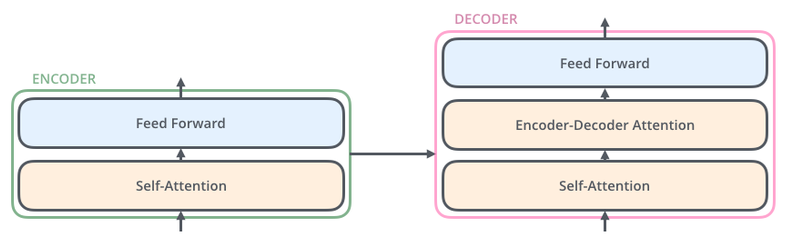
- 인코더-디코더 어텐션
  - Query는 디코더의 현재 시점에서의 출력에서 생성
  - Key와 Value는 인코더의 출력에서 생성
    - 디코더가 인코더의 정보를 활용할 수 있음

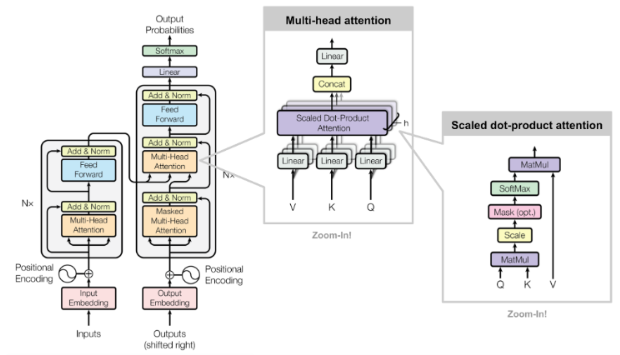
### 4.4.1 디코더 하나의 레이어 함수 정의

In [21]:
# 디코더 하나의 레이어를 함수로 구현.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  #################### 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션) ####################
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 어텐션 결과를 LayerNormalization
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  #################### 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션) ####################
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 어텐션 결과를 Dropout과 LayerNormalization
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  ##################### 세 번째 서브 레이어 : 2개의 완전연결층 (피드 포워드 신경망) ####################
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과를 Dropout과 LayerNormalization
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)


  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 4.4.2 디코더 만들기
- 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결
- 디코더 층을 쌓아 원하는 만큼 반복
  - 파라미터 : num_layers 
  - = Transformer encoder (num_layers)

In [22]:
# 디코더 함수 선언; Transformer의 인코더
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 4.5 Transformer 함수를 정의
- 인코더 함수, 디코더 함수를 사용
- enc_padding_mask : 코더에서 패딩을 위한 마스크
- look_ahead_mask : 디코더에서 미래의 토큰을 마스크
  - 내부적으로 패딩 마스크도 포함되어 있음
- dec_padding_mask : 인코더-디코더 어텐션에서 인코더의 벡터들을 마스킹
- encoder : 인코더
- decoder : 디코더
- outputs : 완전 연결 층

In [23]:
# Transformer 함수를 정의
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## 4.6 모델 생성
- transformer()
- 하이퍼 파라미터 :
  - num_layers : 인코더와 디코더의 층의 개수
  - D_MODEL : 인코더와 디코더 내부의 입,출력의 고정 차원
  - UNITS : 피드 포워드 신경망의 은닉층의 크기
  - NUM_HEADS : 멀티 헤드 어텐션에서의 헤드 수 
  - DROPOUT : 드롭아웃의 비율

### 4.6.1 모델 생성

In [24]:
# 모델 생성
tf.keras.backend.clear_session()

NUM_LAYERS = 2 
D_MODEL = 256 
NUM_HEADS = 8 
UNITS = 512 
DROPOUT = 0.1 

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3144192     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

### 4.6.2 손실 함수 정의
- 레이블 시퀀스에 padding이 적용되어 있음
  - => loss 계산할 때, padding mask를 적용

In [25]:
# 손실함수 선언
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### 4.6.3 커스텀 학습률
- 커스텀 학습률 : 
  - 모델학습 초기에 learning rate를 급격히 높였다가
  - rain step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 함

In [26]:
# 커스텀 학습률 스케줄러 적용 adam optimizer 클래스를 선언
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

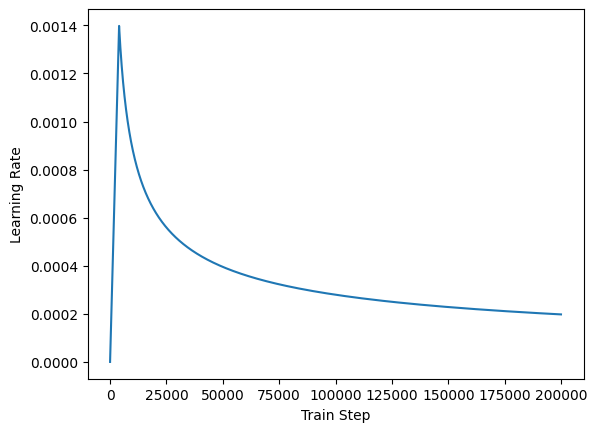

In [27]:
# 커스텀 학습률 스케줄링 계획을 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 4.6.4 모델 컴파일
- 손실 함수와 커스텀 된 학습률(learning rate)을 사용

In [28]:
# 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 4.6.5 모델 훈련
- epochs = 반복횟수

In [29]:
# # 콜백 설정

# # 체크포인트
# checkpoint_path = "model_weights.h5" 
# checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     checkpoint_path, 
#     monitor='val_loss',  
#     verbose=1, 
#     save_best_only=True,  
#     mode='min'  
# )

# # 조기종료
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', 
#     patience=3,  
#     verbose=1, 
#     mode='min'
# )

In [30]:
# 모델 학습 진행
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 18s 57ms/step - loss: 3.3405 - accuracy: 0.0881
Epoch 2/20
185/185 [==============================] - 11s 57ms/step - loss: 2.5615 - accuracy: 0.1543
Epoch 3/20
185/185 [==============================] - 10s 56ms/step - loss: 2.0219 - accuracy: 0.1587
Epoch 4/20
185/185 [==============================] - 10s 53ms/step - loss: 1.8329 - accuracy: 0.1685
Epoch 5/20
185/185 [==============================] - 10s 56ms/step - loss: 1.7050 - accuracy: 0.1757
Epoch 6/20
185/185 [==============================] - 11s 60ms/step - loss: 1.5803 - accuracy: 0.1844
Epoch 7/20
185/185 [==============================] - 11s 60ms/step - loss: 1.4474 - accuracy: 0.1976
Epoch 8/20
185/185 [==============================] - 10s 57ms/step - loss: 1.3020 - accuracy: 0.2152
Epoch 9/20
185/185 [==============================] - 10s 57ms/step - loss: 1.1478 - accuracy: 0.2328
Epoch 10/20
185/185 [==============================] - 10s 56ms/step - loss: 0.987

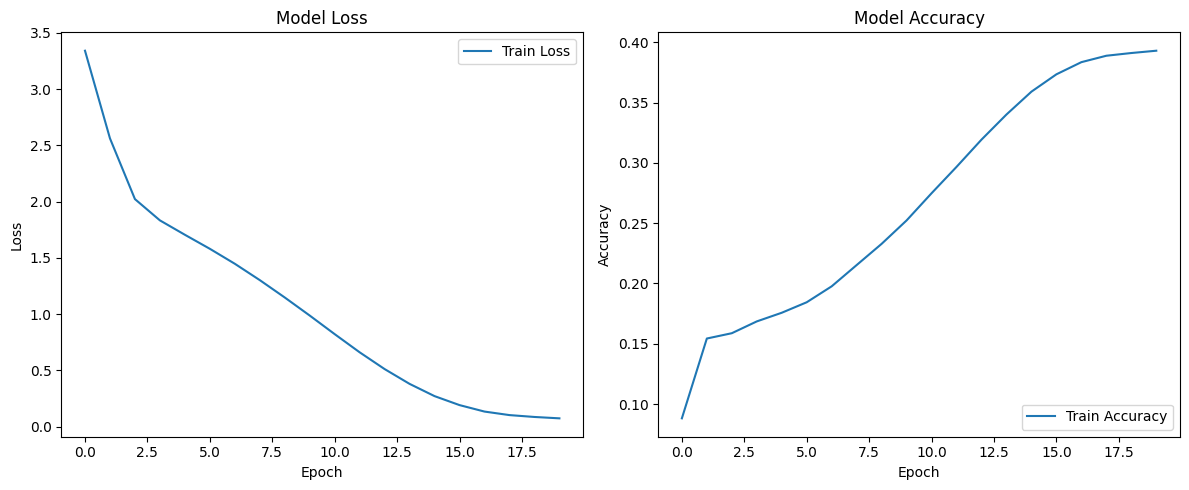

In [31]:
# 전체 그래프 크기 설정
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 위치
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# 정확도 그래프
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 위치
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# 전체 그래프
plt.tight_layout() 
plt.show()

## 5. 모델 평가
### 5.1 디코더 추론 단계
- `decoder_inference()`
1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [32]:
# 위에서 설명한 예측 과정을 수행하는 함수 선언
def decoder_inference(sentence):
  # 1. 문장 전처리
  sentence = preprocess_sentence(sentence)

  # 2. 정수 인코딩과 토큰 추가
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 3. 디코더 출력 시퀀스 초기화
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 4. 디코더 예측 반복
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]
    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break
    # 5. 예측된 토큰의 추가
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  # 6. 결과 반환
  return tf.squeeze(output_sequence, axis=0)

### 5.2 챗봇의 대답을 획득
- `decoder_inference()` 에 임의의 문장을 입력
- `sentence_generation()` 로 챗봇 대답 획득

In [33]:
# 함수 정의
# 임의의 문장을 입력하면 decoder_inference()로 챗봇의 대답을 획득
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [40]:
sentence_kr = '영화 보러 가자'

epochs_n = sentence_generation(sentence_kr)

입력 : 영화 보러 가자
출력 : 살 수 있는 게 살아온 삶 . 차분히 생각해봐요 . 느낌이 들나 봐요 . 기다려보세요 .


In [35]:
sentence_kr = input(str('입력: '))

sentence_generation(sentence_kr)

입력 : 
출력 : 당신이 힘들지 않았으면 것보다 주는 게 더 행복하고 , 더 주고 싶은 마음인 것 같아요 .


'당신이 힘들지 않았으면 것보다 주는 게 더 행복하고 , 더 주고 싶은 마음인 것 같아요 .'

##### NUM_LAYERS = 2 , D_MODEL = 256 , NUM_HEADS = 8

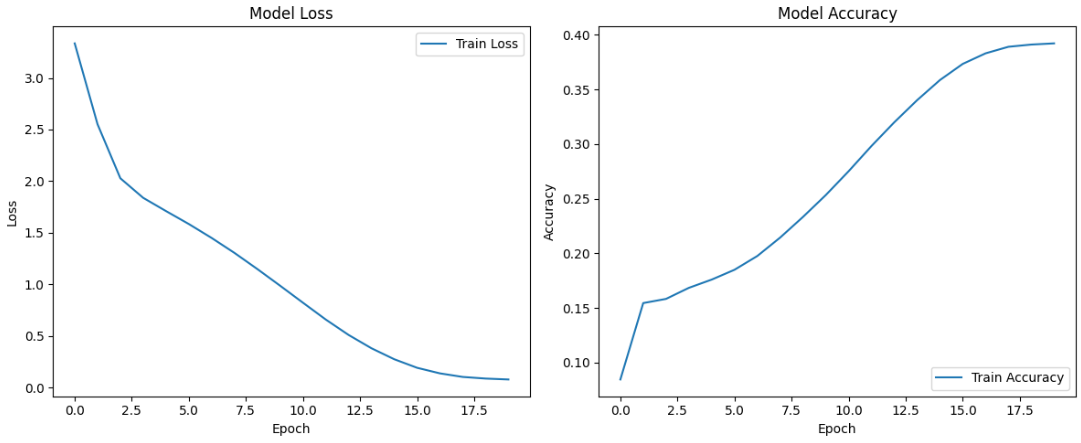
- epoch = 20
  - 입력 : 우리 영화 보러 가자
  - 출력 : 살 수 있는 게 살아온 삶 . 차분히 생각해봐요 . 느낌이 들나 봐요 . 기다려보세요 .
  - 입력 : 나 고민이 있어
  - 출력 : 시간이 필요한 때부터 조언이 아니라 귀 기울여봐요 . 이미 답은 정해져 있을지도 몰라요 .  .

- epoch = 15
  - 입력 : 영화 보러 가자
  - 출력 : 작은 표현으로 표현으로 리드를 다른 일을 하고 자신해 보는 게 좋을 것 같아요 .

- epoch = 10
  - 입력 : 영화 보러 가자
  - 출력 : 먼저 연락을 많이 하거나 더 좋을 건 어떨까요 . 그렇지만 조금 더 좋은 건 어떨까요 . 좋아요 .
  - 입력 : 나 고민이 있어
  - 출력 : 더 좋은 사람 만날 거예요 . 그렇지만 조금 더 좋은 거예요 . 그렇지만 조금 더 상황을 지켜보세요 .

### 회고
- 배운점: transformer의 수행방법과 인코더, 디코더의 차이에 대해 알 수 있었다.
- 아쉬운점: 데이터의 양이 부족하여 결과가 만족스럽지 못했다.
- 느낀점: 셀프어텐션과 멀티어텐션의 차이처럼 병렬로 여러번 처리하면 더 좋은 정보를 얻을 수 있을 것 같다.
- 어려웠던점: 최적의 하이퍼 파라미터와 에포크 수를 찾는 것 